In [1]:
# Changing directory
import os
os.chdir(path=os.getcwd().removesuffix('adialab-notebooks'))

# Modeling
import sklearn.tree
import xgboost as xgb
import sklearn.ensemble
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, KFold

# Visualization
import plotly.express as px
px.defaults.width = 1000
px.defaults.height = 600

# Other
import json
import pandas as pd
import numpy as np
np.random.seed(42)
from typing import List, Dict
from tqdm.notebook import tqdm

In [2]:
# Get important features
def read_json_file(file_path):
    with open(file_path, 'r') as json_file:
        json_data = json_file.read()
    data_list = json.loads(json_data)
    return data_list

In [3]:
features = read_json_file(file_path='narrow-oskar/resources/features.json')

In [4]:
# Get data
X_train = pd.read_parquet('narrow-oskar/data/X_train.parquet')
X_train = X_train.drop(columns=['id']).copy()
X_train = X_train.loc[:, ['date'] + features].copy()
y_train = pd.read_parquet('narrow-oskar/data/y_train.parquet')

### Modeling

### 1. Separate models
I will fit six separate models and calculate scores for each of them.

In [5]:
list_models = [
    sklearn.linear_model.LinearRegression(), # probably the simplest model possible for this problem
    sklearn.linear_model.Lasso(alpha=1), # alpha is a constant that multiplies the L1 term, controlling regularization strength. I require maximum penalty.
    sklearn.linear_model.RANSACRegressor(random_state=42), # RANSAC (RANdom SAmple Consensus) algorithm. RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set.
    sklearn.tree.DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50), # pre pruning
    sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1), # the very same parameters as for the DecisionTree
    xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1), # default parameters
]

In [6]:
def get_rank_corr_score(
    y_preds: pd.DataFrame = None,
    y_trues: pd.DataFrame = None,
) -> float:
    
    rank_pred = y_preds.groupby(by='date', group_keys=True).apply(lambda x: x.rank(pct=True, method='first'))    
    correlation_score = np.corrcoef(rank_pred['y'], y_trues['y'])[0, 1]
    return np.round(correlation_score, 3)

In [7]:
def get_kfold_cv_scores_for_separate_models(
    list_models: List = None,
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique() 
    kfcv = KFold(n_splits=n_splits)
    PURGE = 1
 
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(kfcv.split(dates)):
        
        # Purge 1 date
        if test.min() > train.max():
            train = train[:-PURGE]
        elif test.max() < train.min():
            train = train[PURGE:]
        elif test.min() > train.min() and test.max() < train.max():
            train = np.concatenate((train[train < test.min()][:-PURGE], train[train > test.max()][PURGE:]))
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        for model in list_models:
            model_name = model.__class__.__name__
            if model_name == 'Lasso':
                # Standardize features using only the training set
                scaler = StandardScaler()
                scaler.fit(fold_train_X)
                fold_train_X = scaler.transform(fold_train_X)
                fold_test_X = scaler.transform(fold_test_X)             
            model.fit(fold_train_X, fold_train_y.loc[:, 'y'])  
            preds = model.predict(fold_test_X)
            sample_pred.loc[:, 'y'] = preds.astype(float) 
            score = get_rank_corr_score(sample_pred, fold_test_y)            
            if model_name in stats_CV:
                stats_CV[model_name].append(score)
            else:
                stats_CV[model_name] = [score]
    return stats_CV

In [8]:
def get_walk_forward_fixed_origin_cv_scores_for_separate_models(
    list_models: List = None,
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique()
    tscv = TimeSeriesSplit(n_splits=n_splits)
    PURGE = 1
    
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(tscv.split(dates)):
        
        # Purge 1 date
        train = train[:-PURGE]
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        for model in list_models:
            model_name = model.__class__.__name__
            if model_name == 'Lasso':
                # Standardize features using only the training set
                scaler = StandardScaler()
                scaler.fit(fold_train_X)
                fold_train_X = scaler.transform(fold_train_X)
                fold_test_X = scaler.transform(fold_test_X)        
            model.fit(fold_train_X, fold_train_y.loc[:, 'y'])  
            preds = model.predict(fold_test_X)
            sample_pred.loc[:, 'y'] = preds.astype(float) 
            score = get_rank_corr_score(sample_pred, fold_test_y)            
            if model_name in stats_CV:
                stats_CV[model_name].append(score)
            else:
                stats_CV[model_name] = [score]
    return stats_CV

In [9]:
def rolling_window_split(
    n_samples: int = None,
    train_size: int = None,
    test_size: int = None,
    step: int = 1,
    purge: int = 0,
) -> List:
    """
    Generate rolling window train-test splits.

    Parameters:
    n_samples (int): Total number of samples in the time series.
    train_size (int): Size of the training set in each split.
    test_size (int): Size of the test set in each split.
    step (int, optional): Number of steps to move the window. Default is 1.
    purge (int, optional): Gap between train and test indexes. Default is 0.

    Returns:
    List of tuples: Each tuple contains train indexes and test indexes.
    """

    splits = []
    start_idx = 0
    
    while start_idx + train_size + test_size <= n_samples:
        train_end = start_idx + train_size
        test_start = train_end + purge
        test_end = test_start + test_size
        if train_end not in np.arange(n_samples + 1):
            break
        elif test_start not in np.arange(n_samples + 1):
            break
        elif test_end not in np.arange(n_samples + 1):
            break
        
        train_indexes = list(range(start_idx, train_end))
        test_indexes = list(range(test_start, test_end))

        splits.append((train_indexes, test_indexes))
        start_idx += step

    return splits

def get_walk_forward_rolling_origin_cv_scores_for_separate_models(
    list_models: List = None,
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    test_size: int = None,
    train_size: int = None,
    step: int = 1,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_data['date'].unique()
    min_date = dates.min()
    n_samples = len(dates)
    PURGE = 1

    splits = rolling_window_split(n_samples=n_samples, train_size=train_size, test_size=test_size, step=step, purge=PURGE)
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(splits):
        train += min_date
        test += min_date
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        for model in list_models:
            model_name = model.__class__.__name__
            if model_name == 'Lasso':
                # Standardize features using only the training set
                scaler = StandardScaler()
                scaler.fit(fold_train_X)
                fold_train_X = scaler.transform(fold_train_X)
                fold_test_X = scaler.transform(fold_test_X)
            model.fit(fold_train_X, fold_train_y.loc[:, 'y'])  
            preds = model.predict(fold_test_X)
            sample_pred.loc[:, 'y'] = preds.astype(float) 
            score = get_rank_corr_score(sample_pred, fold_test_y)            
            if model_name in stats_CV:
                stats_CV[model_name].append(score)
            else:
                stats_CV[model_name] = [score]
    return stats_CV

#### Walk Forward CV (fixed origin)

0it [00:00, ?it/s]

LinearRegression model obtained an average score of 0.041 in this CV scheme, with a standard deviation of 0.009
Lasso model obtained an average score of 0.001 in this CV scheme, with a standard deviation of 0.003
RANSACRegressor model obtained an average score of 0.005 in this CV scheme, with a standard deviation of 0.015
DecisionTreeRegressor model obtained an average score of 0.016 in this CV scheme, with a standard deviation of 0.011
RandomForestRegressor model obtained an average score of 0.032 in this CV scheme, with a standard deviation of 0.013
XGBRegressor model obtained an average score of 0.015 in this CV scheme, with a standard deviation of 0.012


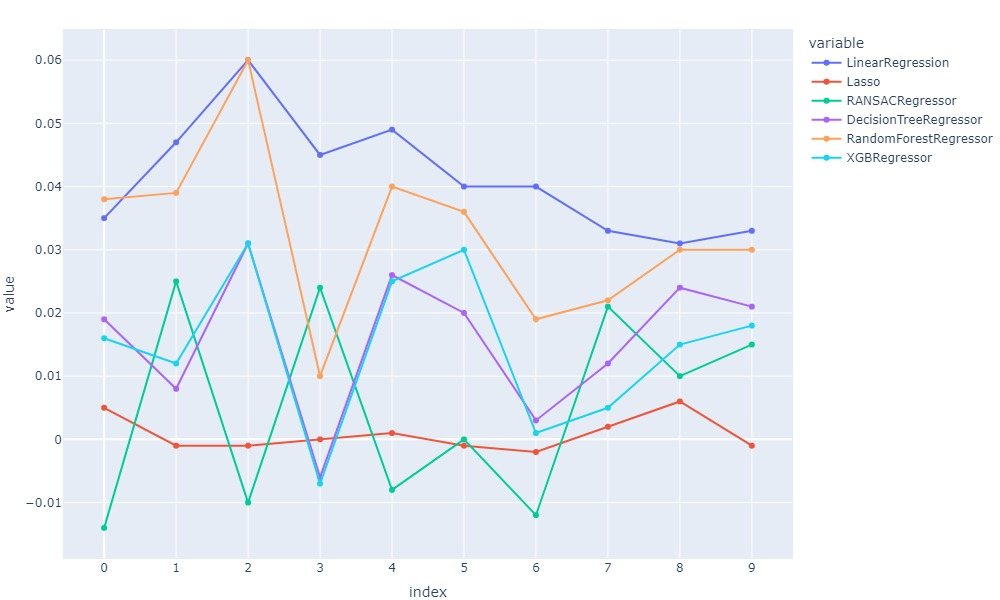

In [10]:
statsCV = get_walk_forward_fixed_origin_cv_scores_for_separate_models(list_models=list_models, X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

#### Walk Forward CV (rolling origin)

  0%|          | 0/258 [00:00<?, ?it/s]

LinearRegression model obtained an average score of 0.033 in this CV scheme, with a standard deviation of 0.086
Lasso model obtained an average score of 0.001 in this CV scheme, with a standard deviation of 0.022
RANSACRegressor model obtained an average score of 0.005 in this CV scheme, with a standard deviation of 0.041
DecisionTreeRegressor model obtained an average score of 0.01 in this CV scheme, with a standard deviation of 0.049
RandomForestRegressor model obtained an average score of 0.026 in this CV scheme, with a standard deviation of 0.083
XGBRegressor model obtained an average score of 0.008 in this CV scheme, with a standard deviation of 0.053


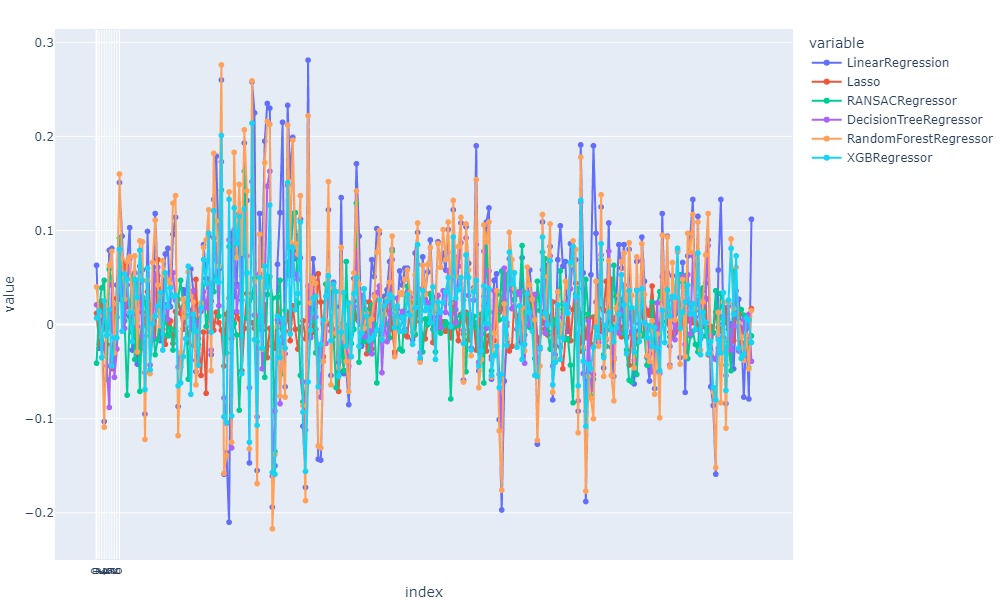

In [11]:
# Arbitrarily chosen train_size and test_size
statsCV = get_walk_forward_rolling_origin_cv_scores_for_separate_models(list_models=list_models, X_data=X_train, y_data=y_train, train_size=10, test_size=1)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

#### K-Fold CV

0it [00:00, ?it/s]

LinearRegression model obtained an average score of 0.043 in this CV scheme, with a standard deviation of 0.012
Lasso model obtained an average score of 0.002 in this CV scheme, with a standard deviation of 0.004
RANSACRegressor model obtained an average score of 0.002 in this CV scheme, with a standard deviation of 0.012
DecisionTreeRegressor model obtained an average score of 0.025 in this CV scheme, with a standard deviation of 0.009
RandomForestRegressor model obtained an average score of 0.04 in this CV scheme, with a standard deviation of 0.012
XGBRegressor model obtained an average score of 0.032 in this CV scheme, with a standard deviation of 0.009


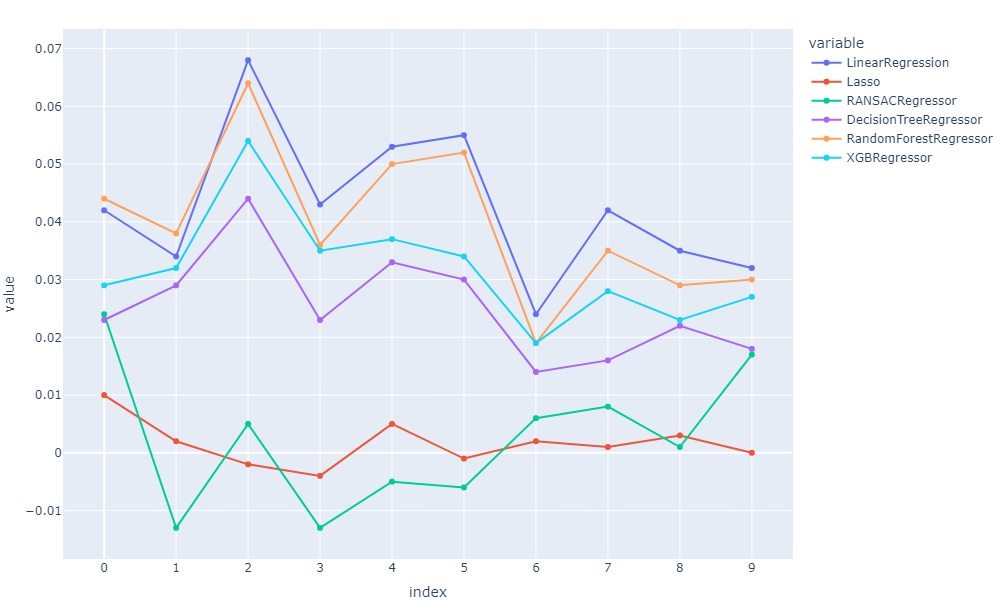

In [12]:
statsCV = get_kfold_cv_scores_for_separate_models(list_models=list_models, X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

* Linear Regression achieves the highest score across all cross-validation schemes, making it the preferred model for the given problem. This aligns with the common usage of linear models in finance.
* Compared to `baseline_modeling.ipynb`, the mean scores for Linear Regression have changed by -6%, +14%, and -19%, respectively.
* In the Fixed Origin Walk Forward CV, the scores for Linear Regression exhibit much smaller standard deviations compared to `baseline_modeling.ipynb`.

### 2. Model averaging
I will fit three separate models and average their predictions.

In [13]:
lr = sklearn.linear_model.LinearRegression() # probably the simplest model possible for this problem
xg = xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1) # the very same hyperparameters as for "separate models"
rf = sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1) # the very same hyperparameters as for "separate models"

In [14]:
def get_kfold_cv_scores_for_model_averaging(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique() 
    kfcv = KFold(n_splits=n_splits)
    PURGE = 1
 
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(kfcv.split(dates)):
        
        # Purge 1 date
        if test.min() > train.max():
            train = train[:-PURGE]
        elif test.max() < train.min():
            train = train[PURGE:]
        elif test.min() > train.min() and test.max() < train.max():
            train = np.concatenate((train[train < test.min()][:-PURGE], train[train > test.max()][PURGE:]))
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        lr = sklearn.linear_model.LinearRegression()
        rf = sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1)
        xg = xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1)
        
        lr.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        lr_preds = lr.predict(fold_test_X)
        
        rf.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        rf_preds = rf.predict(fold_test_X)
        
        xg.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        xg_preds = xg.predict(fold_test_X)
        
        preds = (lr_preds + rf_preds + xg_preds) / 3
        sample_pred.loc[:, 'y'] = preds.astype(float) 
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'average (lr + rf + xgb)'
        
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

In [15]:
def get_walk_forward_fixed_origin_cv_scores_for_model_averaging(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique()
    tscv = TimeSeriesSplit(n_splits=n_splits)
    PURGE = 1
    
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(tscv.split(dates)):
        
        # Purge 1 date
        train = train[:-PURGE]
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        lr = sklearn.linear_model.LinearRegression()
        rf = sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1)
        xg = xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1)
        
        lr.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        lr_preds = lr.predict(fold_test_X)
        
        rf.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        rf_preds = rf.predict(fold_test_X)
        
        xg.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        xg_preds = xg.predict(fold_test_X)
        
        preds = (lr_preds + rf_preds + xg_preds) / 3
        sample_pred.loc[:, 'y'] = preds.astype(float) 
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'average (lr + rf + xgb)'
        
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

In [16]:
def get_walk_forward_rolling_origin_cv_scores_for_model_averaging(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    test_size: int = None,
    train_size: int = None,
    step: int = 1,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_data['date'].unique()
    min_date = dates.min()
    n_samples = len(dates)
    PURGE = 1

    splits = rolling_window_split(n_samples=n_samples, train_size=train_size, test_size=test_size, step=step, purge=PURGE)
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(splits):
        
        train += min_date
        test += min_date
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        sample_pred = fold_test_y.copy()
        lr = sklearn.linear_model.LinearRegression()
        rf = sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1)
        xg = xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1)
        
        lr.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        rf.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        xg.fit(fold_train_X, fold_train_y.loc[:, 'y'])

        lr_preds = lr.predict(fold_test_X)
        rf_preds = rf.predict(fold_test_X)
        xg_preds = xg.predict(fold_test_X)
        
        preds = (lr_preds + rf_preds + xg_preds) / 3
        sample_pred.loc[:, 'y'] = preds.astype(float) 
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'average (lr + rf + xgb)'
        
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

#### Walk Forward CV (fixed origin)

0it [00:00, ?it/s]

average (lr + rf + xgb) model obtained an average score of 0.028 in this CV scheme, with a standard deviation of 0.012


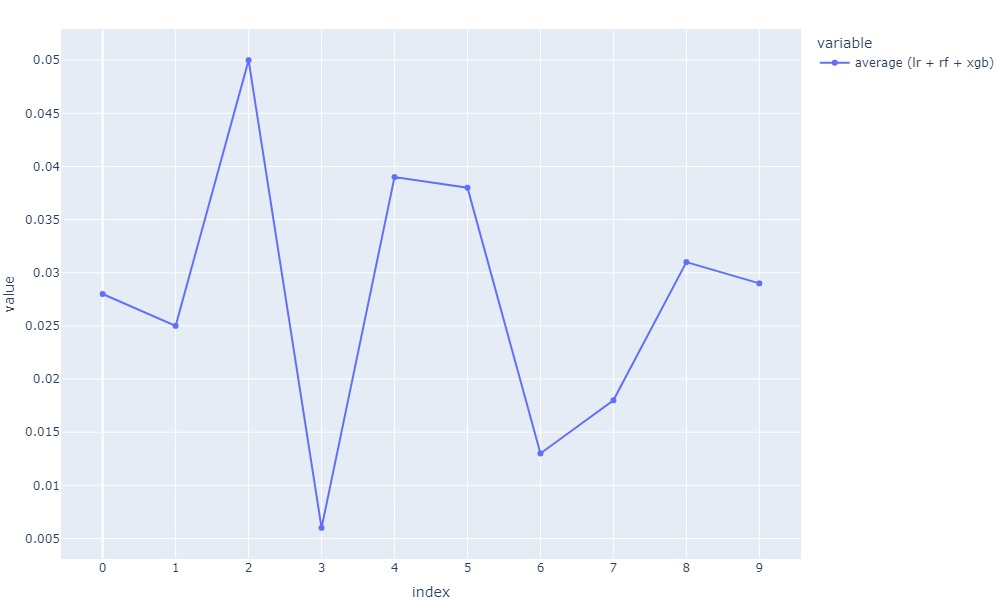

In [17]:
statsCV = get_walk_forward_fixed_origin_cv_scores_for_model_averaging(X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

#### Walk Forward CV (rolling origin)

  0%|          | 0/258 [00:00<?, ?it/s]

average (lr + rf + xgb) model obtained an average score of 0.018 in this CV scheme, with a standard deviation of 0.07


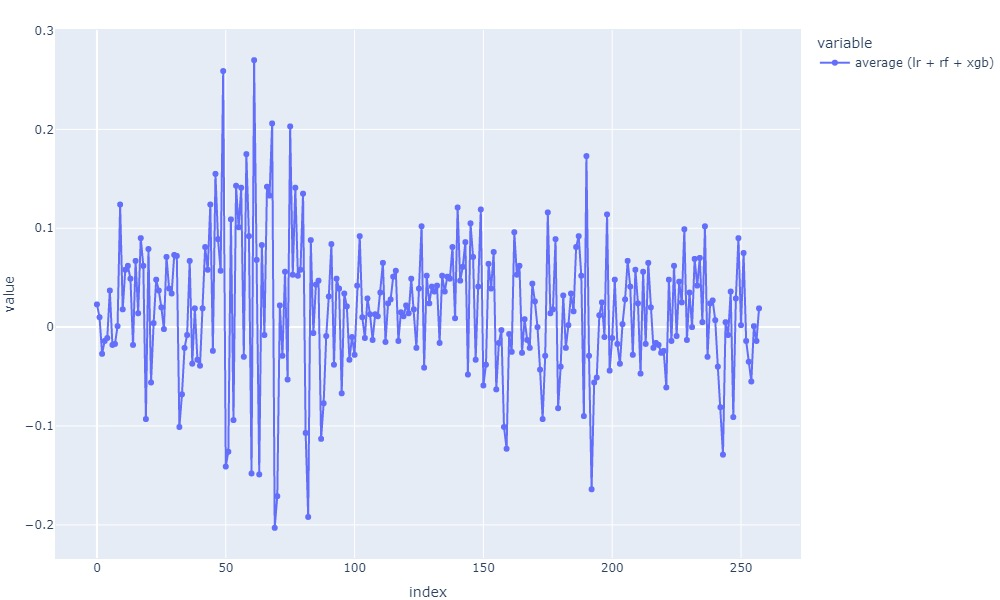

In [18]:
# Arbitrarily chosen train_size and test_size
statsCV = get_walk_forward_rolling_origin_cv_scores_for_model_averaging(X_data=X_train, y_data=y_train, train_size=10, test_size=1)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.show('jpeg')

#### K-Fold CV

0it [00:00, ?it/s]

average (lr + rf + xgb) model obtained an average score of 0.04 in this CV scheme, with a standard deviation of 0.011


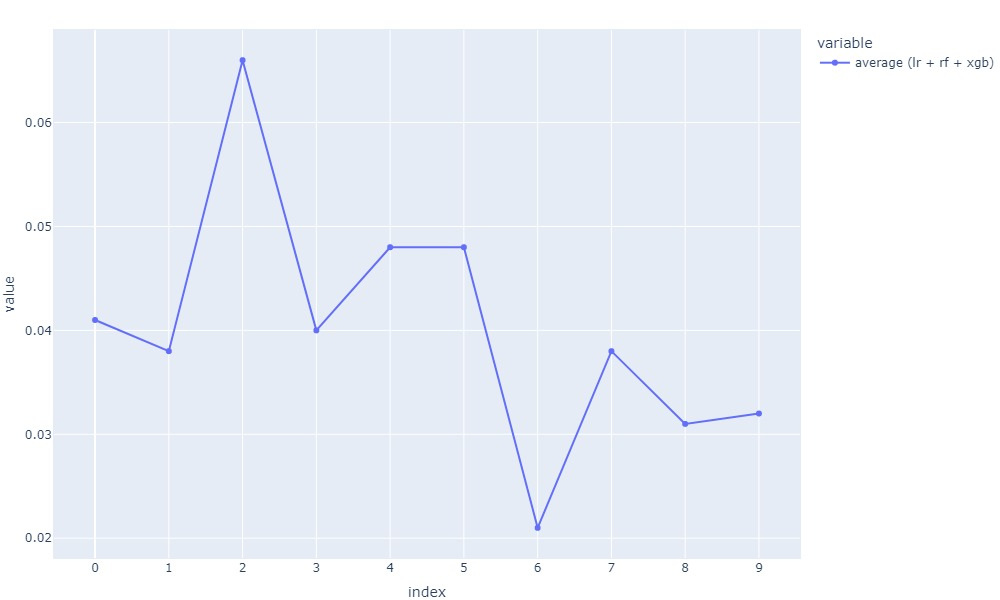

In [19]:
statsCV = get_kfold_cv_scores_for_model_averaging(X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

* Linear Regression beats model averaging in each cross-validation scheme.
* Compared to `baseline_modeling.ipynb` the mean scores have changed by -20%, -30%, and -20%, respectively.

### 3. Model stacking

In [20]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', sklearn.linear_model.LinearRegression()),
    ('rf', sklearn.ensemble.RandomForestRegressor(random_state=42, max_depth=6, min_samples_split=100, min_samples_leaf=50, n_jobs=-1)), # the very same hyperparameters as for "separate models"
    ('xg', xgb.XGBRegressor(seed=42, max_depth=6, learning_rate=0.3, colsample_bytree=1, n_jobs=-1)) # the very same hyperparameters as for "separate models"
]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=sklearn.linear_model.LinearRegression()
)

In [21]:
def get_kfold_cv_scores_for_model_stacking(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique() 
    kfcv = KFold(n_splits=n_splits)
    PURGE = 1
 
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(kfcv.split(dates)):
        
        # Purge 1 date
        if test.min() > train.max():
            train = train[:-PURGE]
        elif test.max() < train.min():
            train = train[PURGE:]
        elif test.min() > train.min() and test.max() < train.max():
            train = np.concatenate((train[train < test.min()][:-PURGE], train[train > test.max()][PURGE:]))
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        reg.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        preds = reg.predict(fold_test_X)
        sample_pred = fold_test_y.copy()
        sample_pred.loc[:, 'y'] = preds.astype(float)
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'stacking'
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

In [22]:
def get_walk_forward_fixed_origin_cv_scores_for_model_stacking(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_train['date'].unique()
    tscv = TimeSeriesSplit(n_splits=n_splits)
    PURGE = 1
    
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(tscv.split(dates)):
        
        # Purge 1 date
        train = train[:-PURGE]
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        reg.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        preds = reg.predict(fold_test_X)
        sample_pred = fold_test_y.copy()
        sample_pred.loc[:, 'y'] = preds.astype(float)
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'stacking'
        
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

In [23]:
def get_walk_forward_rolling_origin_cv_scores_for_model_stacking(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    test_size: int = None,
    train_size: int = None,
    step: int = 1,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_data['date'].unique()
    min_date = dates.min()
    n_samples = len(dates)
    PURGE = 1

    splits = rolling_window_split(n_samples=n_samples, train_size=train_size, test_size=test_size, step=step, purge=PURGE)
    # Store performance in a dict
    stats_CV = {}
    for train, test in tqdm(splits):
        
        train += min_date
        test += min_date
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :]
        fold_train_y = y_data.loc[y_data['date'].isin(train), :]

        fold_test_X = X_data.loc[X_data['date'].isin(test), :]
        fold_test_y = y_data.loc[y_data['date'].isin(test), :]
        
        reg.fit(fold_train_X, fold_train_y.loc[:, 'y'])
        preds = reg.predict(fold_test_X)
        sample_pred = fold_test_y.copy()
        sample_pred.loc[:, 'y'] = preds.astype(float)
        score = get_rank_corr_score(sample_pred, fold_test_y)            
        
        model_name = 'stacking'
        if model_name in stats_CV:
            stats_CV[model_name].append(score)
        else:
            stats_CV[model_name] = [score]
            
    return stats_CV

#### Walk Forward CV (fixed origin)

0it [00:00, ?it/s]

stacking model obtained an average score of 0.041 in this CV scheme, with a standard deviation of 0.009


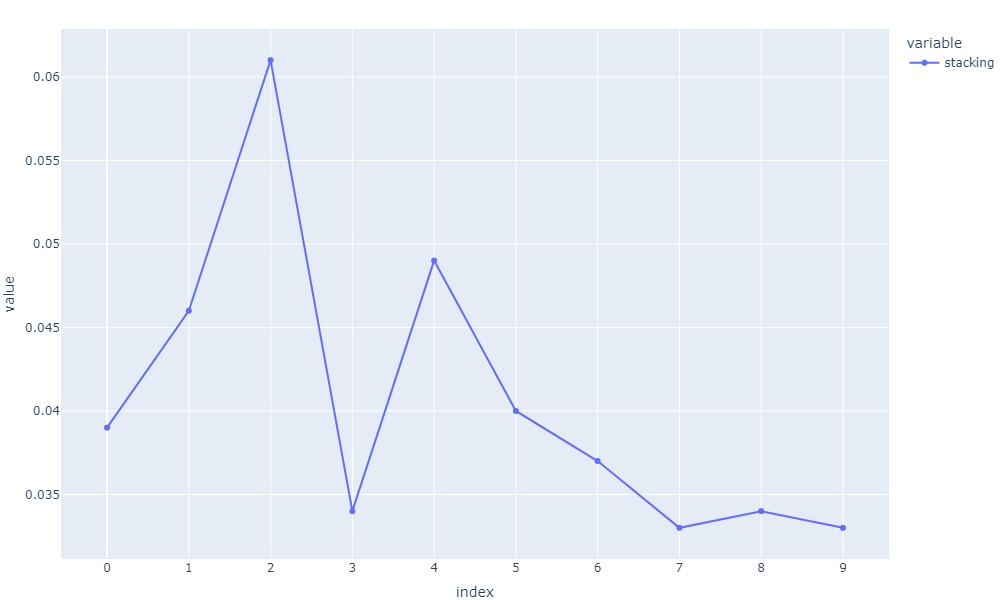

In [24]:
statsCV = get_walk_forward_fixed_origin_cv_scores_for_model_stacking(X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

#### Walk Forward CV (rolling origin)

  0%|          | 0/258 [00:00<?, ?it/s]

stacking model obtained an average score of 0.023 in this CV scheme, with a standard deviation of 0.083


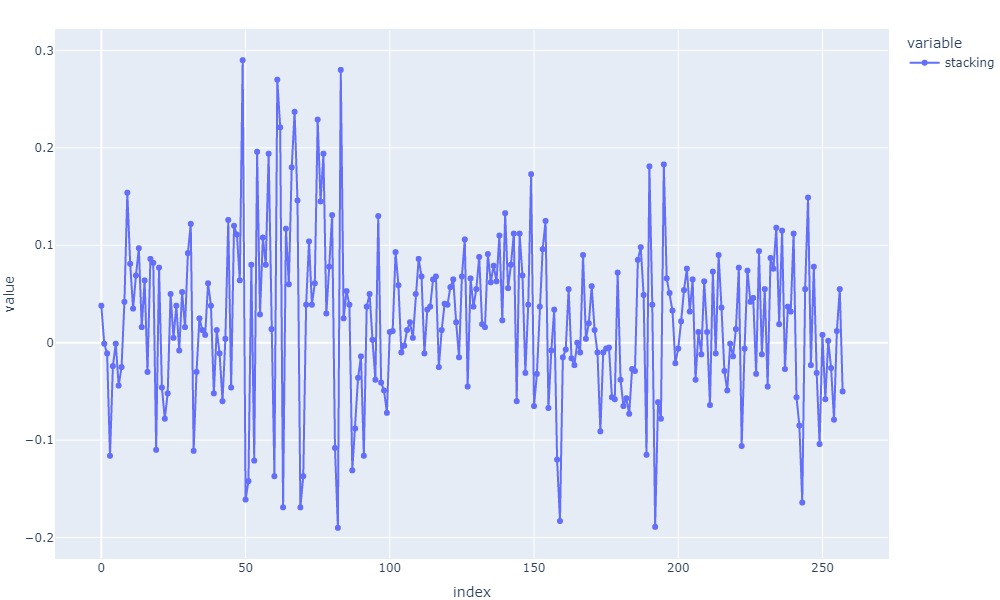

In [25]:
# Arbitrarily chosen train_size and test_size
statsCV = get_walk_forward_rolling_origin_cv_scores_for_model_stacking(X_data=X_train, y_data=y_train, train_size=10, test_size=1)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.show('jpeg')

#### K-Fold CV

0it [00:00, ?it/s]

stacking model obtained an average score of 0.043 in this CV scheme, with a standard deviation of 0.012


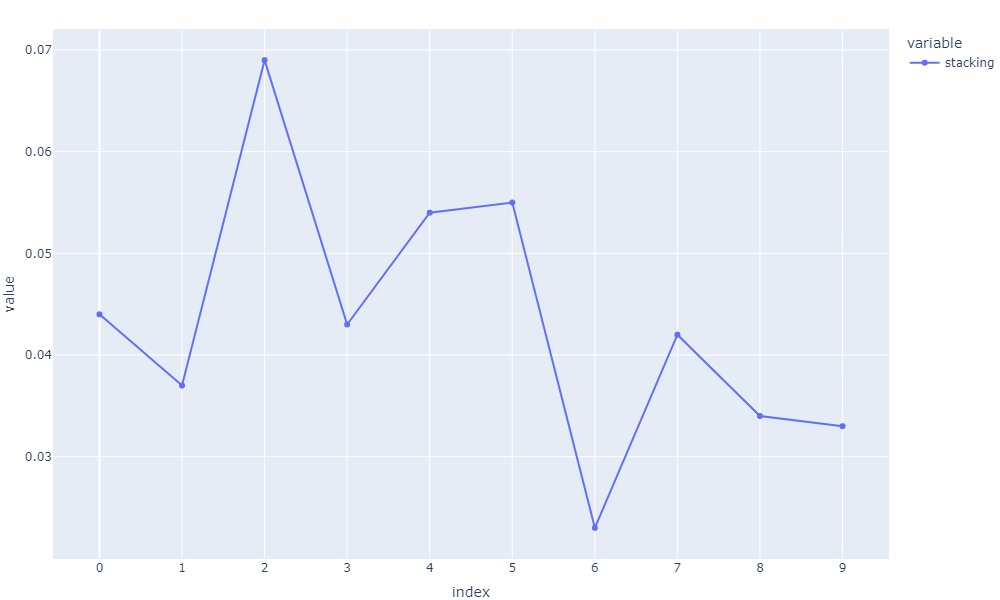

In [26]:
statsCV = get_kfold_cv_scores_for_model_stacking(X_data=X_train, y_data=y_train, n_splits=10)
for key, item in statsCV.items():
    print(f'{key} model obtained an average score of {str(np.round(np.mean(item), 3))} in this CV scheme, with a standard deviation of {str(np.round(np.std(item), 3))}')
fig = px.line(data_frame=statsCV, markers='.')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=1), hovermode=False)
fig.update_xaxes(tickvals=np.arange(start=0, stop=10))
fig.show('jpeg')

* Model stacking yields results similar to Linear Regression despite its complexity.
* In comparison to `baseline_modeling.ipynb`, the mean scores for Linear Regression have changed by -10%, +10%, and -21%, respectively.
* The decrease in scores is acceptable considering that the number of features is roughly 20 times fewer than before.
* The official winner is now Linear Regression with features stored in the `features.json` file.